<a href="https://colab.research.google.com/github/LeylaY1996/sentiment-analysis-aws-reviews/blob/main/30122024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# Veri setini yükle
csv_file_path = '/content/Reviews-2.csv'  # Dosya yolunuza göre güncelleyin
df = pd.read_csv(csv_file_path, on_bad_lines='skip', quoting=3, low_memory=False)  # daha yeni versiyonlar için
# Veri setinin boyutunu yazdır
print("Orijinal veri seti boyutu:", df.shape)

# %50 oranında rastgele bir alt küme seç
#sampled_df = df.sample(frac=0.5, random_state=42)  # random_state ile tekrarlanabilirlik sağlar

# Yeni veri setinin boyutunu yazdır
#print("Yeni veri seti boyutu:", sampled_df.shape)

# İstediğiniz gibi veriyi kaydedin veya kullanın
#sampled_df.to_csv('sampled_reviews.csv', index=False)  # Yeni dosyayı kaydet

Orijinal veri seti boyutu: (149388, 10)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


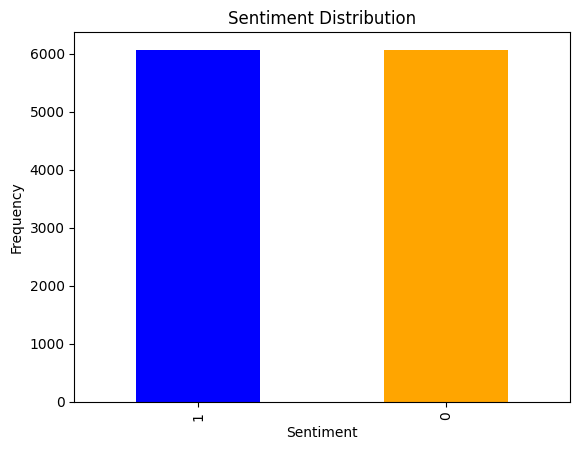

Ortalama Yorum Uzunluğu: 139.837343441002
Standart Sapma: 89.755888745872
                                          cleaned_review  Sentiment  \
30703  fog chaser tastiest full bodied coffee kerig m...          1   
14176  buy case regularly rather hard find stores son...          1   
30281  love much better wheat thins competitorsless s...          1   
9818   really enjoy coffee one best flavored coffee k...          1   
34003  good price wonderful product would definetly o...          1   
...                                                  ...        ...   
28678  got noodle excited try ate two bite going sink...          0   
39304  bought son christmas like dr pepper really dis...          0   
39638  bough france quality super one received disapp...          0   
41195  company basically selling ordinary honey bees ...          0   
6434   dont buy treats unless want clean vomit day ma...          0   

        ProductId          UserId  
30703  B007Y59HVM  A23FXN3MH1F00D  
1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
from scipy import stats

# NLTK stopwords yükle
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
punctuation = string.punctuation

def clean_text(text):
    """Metni temizler: küçük harfe çevirir, noktalama işaretlerini kaldırır ve durak kelimeleri filtreler."""
    text = text.lower()  # Küçük harfe çevir
    text = ''.join([char for char in text if char not in punctuation])  # Noktalama işaretlerini kaldır
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Durak kelimeleri filtrele
    return text

def prepare_data(csv_file):
    """Veri setini hazırlar: yükler, temizler ve etiketler."""

    # Veri setini yükle
    df = pd.read_csv(csv_file)

    # Gerekli sütunları seçin
    df = df[['Text', 'Score', 'ProductId', 'UserId']]

    # 3 değerine sahip satırları çıkarın
    df = df[df['Score'] != 3]

    # Skorları ikili hale getirin (örneğin: 1-2 olumsuz, 4-5 olumlu)
    df['Sentiment'] = df['Score'].apply(lambda x: 1 if x >= 4 else 0)

    # Yorumları temizle
    df['cleaned_review'] = df['Text'].apply(clean_text)

    # Sadece temizlenmiş yorumlar ve duygu etiketlerini içeren DataFrame döndür
    return df[['cleaned_review', 'Sentiment', 'ProductId', 'UserId']]

# Veriyi yükle ve hazırla
csv_file_path = '/content/sampled_reviews.csv'  # Dosya yolunuza göre güncelleyin
prepared_data = prepare_data(csv_file_path)

# Veri dengesini sağlama
# Olumlu ve olumsuz örneklerin sayısını bul
positive_samples = prepared_data[prepared_data['Sentiment'] == 1]
negative_samples = prepared_data[prepared_data['Sentiment'] == 0]

# Minimum sayıda olan sınıfa göre dengeleme
min_samples = min(len(positive_samples), len(negative_samples))
balanced_data = pd.concat([positive_samples.sample(min_samples, random_state=42),
                           negative_samples.sample(min_samples, random_state=42)])

# Histogram çizme
balanced_data['Sentiment'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

# Ortalama ve standart sapma hesaplama
mean_length = balanced_data['cleaned_review'].apply(len).mean()
std_length = balanced_data['cleaned_review'].apply(len).std()
print(f"Ortalama Yorum Uzunluğu: {mean_length}")
print(f"Standart Sapma: {std_length}")

# Aykırı değer kontrolü (örneğin, yorum uzunluğuna göre aykırı değer)
z_scores = np.abs(stats.zscore(balanced_data['cleaned_review'].apply(len)))
balanced_data = balanced_data[(z_scores < 3)]
print(balanced_data)
print("Aykırı değerler çıkarıldıktan sonra veri seti boyutu:", balanced_data.shape)

In [3]:
# Confusion Matrix'i görselleştir
def plot_confusion_matrix(cm):
    """Confusion matrix'i görselleştirir."""
    fig, ax = plt.subplots(figsize=(6,6))
    ax.matshow(cm, cmap='Blues', alpha=0.6)
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f'{val}', ha='center', va='center', color='red')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize_text(train_text, test_text, max_features=10000, ngram_range=(1, 2)):
    """
    Metinleri TF-IDF ile vektörize eder.
    """
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    X_train_tfidf = vectorizer.fit_transform(train_text)
    X_test_tfidf = vectorizer.transform(test_text)
    return X_train_tfidf, X_test_tfidf, vectorizer

In [5]:
from sklearn.model_selection import train_test_split

def split_data(df, feature_column, target_column, test_size=0.2, random_state=42):
    """
    Veri çerçevesini eğitim ve test setine böler.

    Args:
    - df: Veri çerçevesi (pandas DataFrame).
    - feature_column: Özellik sütunu adı (ör. metin verisi).
    - target_column: Hedef sütunu adı (etiketler).
    - test_size: Test setinin boyutu (varsayılan: 0.2).
    - random_state: Rastgele durum kontrolü için tohum (varsayılan: 42).

    Returns:
    - X_train: Eğitim seti özellikleri.
    - X_test: Test seti özellikleri.
    - y_train: Eğitim seti etiketleri.
    - y_test: Test seti etiketleri.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        df[feature_column],
        df[target_column],
        test_size=test_size,
        random_state=random_state,
        stratify=df[target_column]  # Sınıf dengesini korumak için stratify
    )
    return X_train, X_test, y_train, y_test

In [6]:
from imblearn.over_sampling import SMOTE

def apply_smote(X, y, random_state=42):
    """
    SMOTE ile azınlık sınıfını artırır.
    """
    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

In [7]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Modeli eğitir ve değerlendirme metriklerini döner.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    return accuracy, report, cm

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


SVM with SMOTE Accuracy (Balanced Data): 0.8959731543624161
SVM with SMOTE Classification Report (Balanced Data):
               precision    recall  f1-score   support

           0       0.89      0.90      0.90      1187
           1       0.90      0.89      0.90      1197

    accuracy                           0.90      2384
   macro avg       0.90      0.90      0.90      2384
weighted avg       0.90      0.90      0.90      2384

SVM with SMOTE Confusion Matrix (Balanced Data):
 [[1073  114]
 [ 134 1063]]


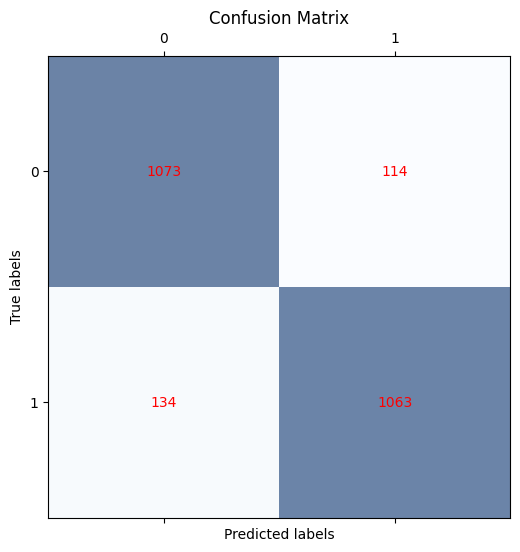

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

def svm_with_smote_sentiment_analysis_balanced(df):
    """Balanced veri seti ile SVM ve SMOTE kullanarak duygu analizi yapar."""

    # Eğitim ve test setine ayırma
    X_train, X_test, y_train, y_test = split_data(df, 'cleaned_review', 'Sentiment')

    # TF-IDF vektörleştirme
    X_train_tfidf, X_test_tfidf, _ = vectorize_text(X_train, X_test)

    # SMOTE ile veri dengeleme
    X_train_resampled, y_train_resampled = apply_smote(X_train_tfidf, y_train)

    # SVM modeli oluştur ve değerlendir
    model = SVC(kernel='linear', class_weight='balanced', random_state=42)
    accuracy, report, cm = train_and_evaluate_model(
        model, X_train_resampled, y_train_resampled, X_test_tfidf, y_test
    )

    return accuracy, report, cm

# SVM analizi
accuracy, report, cm = svm_with_smote_sentiment_analysis_balanced(balanced_data)

# Sonuçları yazdır
print("SVM with SMOTE Accuracy (Balanced Data):", accuracy)
print("SVM with SMOTE Classification Report (Balanced Data):\n", report)
print("SVM with SMOTE Confusion Matrix (Balanced Data):\n", cm)

plot_confusion_matrix(cm)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Naive Bayes with SMOTE Accuracy: 0.8926174496644296
Naive Bayes with SMOTE Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      1187
           1       0.88      0.91      0.90      1197

    accuracy                           0.89      2384
   macro avg       0.89      0.89      0.89      2384
weighted avg       0.89      0.89      0.89      2384

Naive Bayes with SMOTE Confusion Matrix:
 [[1034  153]
 [ 103 1094]]


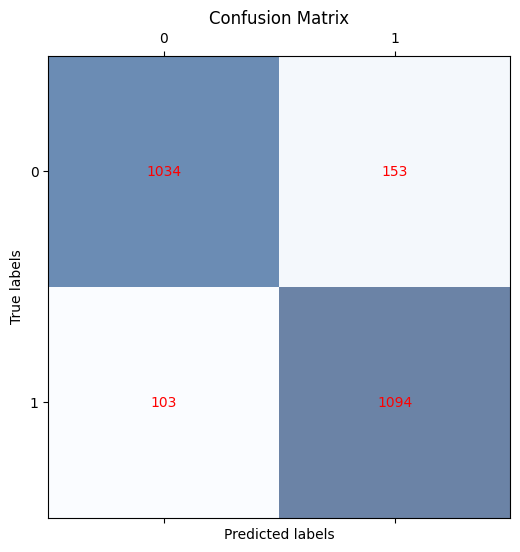

In [9]:
from sklearn.naive_bayes import MultinomialNB

def naive_bayes_with_smote_sentiment_analysis(df):
    """Naive Bayes ve SMOTE kullanarak duygu analizi yapar."""

    # Eğitim ve test setine ayırma
    X_train, X_test, y_train, y_test = split_data(df, 'cleaned_review', 'Sentiment')

    # TF-IDF vektörleştirme
    X_train_tfidf, X_test_tfidf, _ = vectorize_text(X_train, X_test)

    # SMOTE ile veri dengeleme
    X_train_resampled, y_train_resampled = apply_smote(X_train_tfidf, y_train)

    # Naive Bayes modelini oluştur
    model = MultinomialNB()

    # Modeli eğit ve değerlendir
    accuracy, report, cm = train_and_evaluate_model(
        model, X_train_resampled, y_train_resampled, X_test_tfidf, y_test
    )

    return accuracy, report, cm

# Naive Bayes analizi
accuracy, report, cm = naive_bayes_with_smote_sentiment_analysis(balanced_data)

# Sonuçları yazdır
print("Naive Bayes with SMOTE Accuracy:", accuracy)
print("Naive Bayes with SMOTE Classification Report:\n", report)
print("Naive Bayes with SMOTE Confusion Matrix:\n", cm)

plot_confusion_matrix(cm)

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def preprocess_text_with_tokenizer(train_text, test_text, max_length=100):
    """
    Metinleri tokenize eder ve belirli bir uzunlukta padding uygular.
    """
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_text)

    # Sayısal verilere dönüştürme
    train_seq = tokenizer.texts_to_sequences(train_text)
    test_seq = tokenizer.texts_to_sequences(test_text)

    # Padding işlemi
    train_padded = pad_sequences(train_seq, maxlen=max_length, padding='post')
    test_padded = pad_sequences(test_seq, maxlen=max_length, padding='post')

    return train_padded, test_padded, tokenizer

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

def build_rnn_model(input_dim, max_length, embedding_dim=100):
    """
    RNN (Bidirectional LSTM) modeli oluşturur.
    """
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=embedding_dim, input_length=max_length))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 79s 468ms/step - accuracy: 0.6203 - loss: 0.8009 - val_accuracy: 0.8826 - val_loss: 0.3027
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 79s 447ms/step - accuracy: 0.9356 - loss: 0.2599 - val_accuracy: 0.8855 - val_loss: 0.3036
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 86s 473ms/step - accuracy: 0.9678 - loss: 0.1501 - val_accuracy: 0.8716 - val_loss: 0.3628
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 79s 456ms/step - accuracy: 0.9793 - loss: 0.0927 - val_accuracy: 0.8775 - val_loss: 0.4136
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 81s 450ms/step - accuracy: 0.9911 - loss: 0.0509 - val_accuracy: 0.8620 - val_loss: 0.5175
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 81s 444ms/step - accuracy: 0.9902 - loss: 0.0497 - val_accuracy: 0.8792 - val_loss: 0.5467
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 82s 446ms/step - accuracy: 0.9975 - loss: 0.0226 - val_accuracy: 0.8750 - val_loss: 0.5787
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 83s 454ms/step - accuracy: 0.9958 - loss: 0

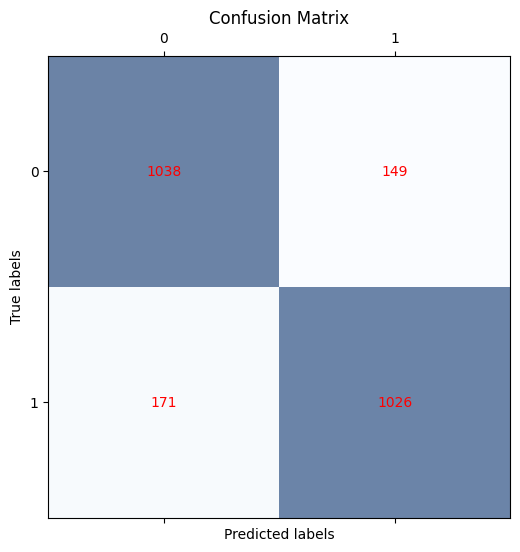

In [12]:
def rnn_with_balancing_smote(df):
    """RNN (Bidirectional LSTM) ve SMOTE kullanarak duygu analizi yapar."""

    # Eğitim ve test setine ayırma
    X_train, X_test, y_train, y_test = split_data(df, 'cleaned_review', 'Sentiment')

    # Metin ön işleme (tokenize ve padding)
    max_length = 100
    X_train_padded, X_test_padded, tokenizer = preprocess_text_with_tokenizer(X_train, X_test, max_length)

    # SMOTE ile veri dengeleme
    X_train_resampled, y_train_resampled = apply_smote(X_train_padded, y_train)

    # Model oluşturma
    input_dim = len(tokenizer.word_index) + 1  # Tokenizer'daki toplam kelime sayısı
    model = build_rnn_model(input_dim, max_length)

    # Modeli eğitme
    model.fit(
        X_train_resampled,
        y_train_resampled,
        epochs=10,
        batch_size=64,
        validation_data=(X_test_padded, y_test),
        class_weight={0: 2, 1: 1}  # Sınıf ağırlıkları
    )

    # Tahmin yap
    y_pred = (model.predict(X_test_padded) > 0.5).astype("int32").flatten()

    # Sonuçları değerlendir
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    return accuracy, report, cm

# Balanced data ile RNN analizi
accuracy, report, cm = rnn_with_balancing_smote(balanced_data)

# Sonuçları yazdır
print("SMOTE ile dengelenmiş RNN Accuracy:", accuracy)
print("SMOTE ile dengelenmiş RNN Classification Report:\n", report)
print("SMOTE ile dengelenmiş RNN Confusion Matrix:\n", cm)

plot_confusion_matrix(cm)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Lexicon-Based SMOTE Accuracy: 0.9388217522658611
Lexicon-Based SMOTE Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.94      5932
           1       0.93      0.95      0.94      5984

    accuracy                           0.94     11916
   macro avg       0.94      0.94      0.94     11916
weighted avg       0.94      0.94      0.94     11916

Lexicon-Based SMOTE Confusion Matrix:
 [[5479  453]
 [ 276 5708]]


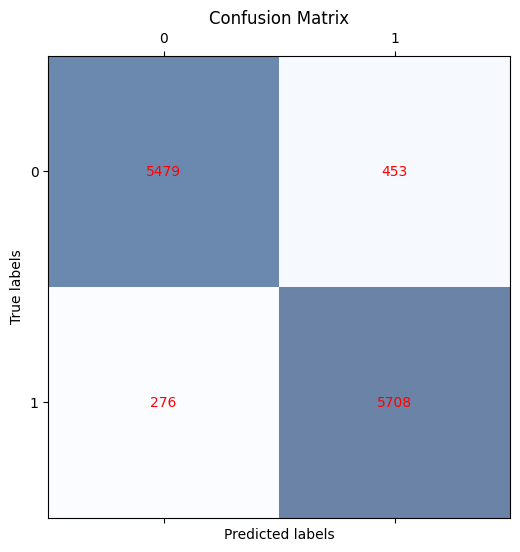

In [13]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Pozitif ve negatif kelimelerin listesi
positive_words = ['good', 'great', 'excellent', 'awesome', 'nice']
negative_words = ['bad', 'terrible', 'poor', 'worst', 'awful']

def lexicon_based_sentiment_analysis_with_smote_balanced(df):
    """Lexicon-based sentiment analizi SMOTE ile ve balanced_data kullanarak."""

    # Her yorumdaki kelimeleri analiz ederek duygu puanı döndür
    def get_sentiment(text):
        words = text.split()
        score = 0
        for word in words:
            if word in positive_words:
                score += 1
            elif word in negative_words:
                score -= 1
        return 1 if score > 0 else 0

    # Duygu etiketlerini tahmin et
    df['Lexicon_Sentiment'] = df['cleaned_review'].apply(get_sentiment)

    # Özellik ve etiketleri ayırma
    X = df['cleaned_review']  # Özellikler: Temizlenmiş yorumlar
    y = df['Sentiment']  # Etiketler: Gerçek duygu etiketleri

    # TF-IDF vektörleştirme
    X_train_tfidf, X_test_tfidf, _ = vectorize_text(X, X)

    # SMOTE uygulama
    X_res, y_res = apply_smote(X_train_tfidf, y)

    # Modeli eğitme ve tahmin
    model = MultinomialNB()
    model.fit(X_res, y_res)
    y_pred = model.predict(X_test_tfidf)

    # Tahminleri değerlendirme
    accuracy = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred)
    cm = confusion_matrix(y, y_pred)

    # Sonuçları yazdır
    print("Lexicon-Based SMOTE Accuracy:", accuracy)
    print("Lexicon-Based SMOTE Classification Report:\n", report)
    print("Lexicon-Based SMOTE Confusion Matrix:\n", cm)

    # Confusion matrix'i görselleştir
    plot_confusion_matrix(cm)

    return accuracy, report, cm

# Lexicon-based fonksiyonunu balanced_data ile çağırma
accuracy, report, cm = lexicon_based_sentiment_analysis_with_smote_balanced(balanced_data)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Aspect-Based Sentiment Analysis with SMOTE
Accuracy: 0.6433823529411765
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.81      0.69      5984
           1       0.71      0.48      0.57      5984

    accuracy                           0.64     11968
   macro avg       0.66      0.64      0.63     11968
weighted avg       0.66      0.64      0.63     11968

Confusion Matrix:
 [[4842 1142]
 [3126 2858]]


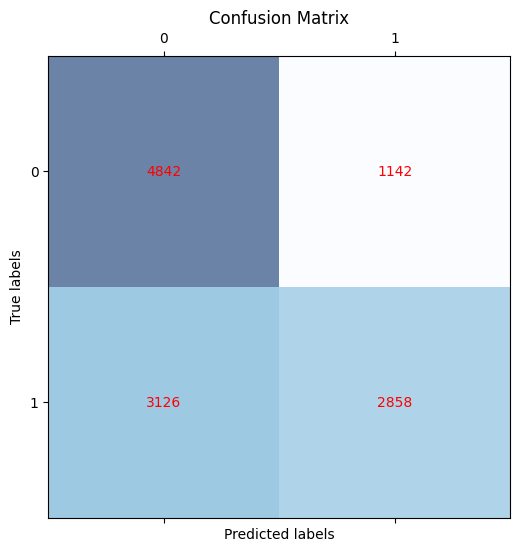

In [15]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

# Aspect kelime listeleri
aspects = {
    'hız': ['fast', 'quick', 'speed', 'late', 'delayed'],
    'kalite': ['good', 'great', 'excellent', 'poor', 'bad', 'terrible', 'quality']
}

def aspect_based_sentiment_analysis_with_smote_balanced(df):
    """Aspect-based sentiment analizi SMOTE ile ve balanced_data kullanarak."""

    # Her özellik için duygu analizi yap
    def get_aspect_sentiment(text):
        words = text.split()
        aspect_scores = {aspect: 0 for aspect in aspects.keys()}
        for word in words:
            for aspect, keywords in aspects.items():
                if word in keywords:
                    aspect_scores[aspect] += 1
        return aspect_scores['hız'], aspect_scores['kalite']

    # Her bir yorum için aspect-based duygu analizi yap
    df[['Aspect_Hız', 'Aspect_Kalite']] = df['cleaned_review'].apply(get_aspect_sentiment).apply(pd.Series)

    # CountVectorizer ile kelime sıklığı (word count) çıkarımı
    vectorizer = CountVectorizer(vocabulary=sum(aspects.values(), []))
    X_aspects = vectorizer.fit_transform(df['cleaned_review']).toarray()

    # SMOTE uygulama (X: özellikler, y: etiketler)
    smote = SMOTE(k_neighbors=3)
    X_res, y_res = apply_smote(X_aspects, df['Sentiment'])

    # Model tanımlama
    model = RandomForestClassifier(random_state=42)

    # Model eğitimi
    model.fit(X_res, y_res)
    y_pred = model.predict(X_res)

    # Sonuçların değerlendirilmesi
    accuracy = accuracy_score(y_res, y_pred)
    report = classification_report(y_res, y_pred)
    cm = confusion_matrix(y_res, y_pred)

    # Sonuçların yazdırılması
    print("Aspect-Based Sentiment Analysis with SMOTE")
    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", cm)

    return accuracy, report, cm

# Aspect-based fonksiyonunu çağırma
accuracy, report, cm = aspect_based_sentiment_analysis_with_smote_balanced(balanced_data)
plot_confusion_matrix(cm)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, pref

Epoch 1/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.7632 - loss: 0.5390 - val_accuracy: 0.8951 - val_loss: 0.2547
Epoch 2/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9637 - loss: 0.1089 - val_accuracy: 0.8985 - val_loss: 0.2771
Epoch 3/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9933 - loss: 0.0358 - val_accuracy: 0.8972 - val_loss: 0.3408
Epoch 4/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.9984 - loss: 0.0118 - val_accuracy: 0.8985 - val_loss: 0.3964
Epoch 5/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9995 - loss: 0.0037 - val_accuracy: 0.8981 - val_loss: 0.4361
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
CNN with SMOTE Accuracy (Balanced Data): 0.8980704697986577
CNN with SMOTE Classification Report (Balanced Data):
               precision    recall  f1-score   support

           0       0.89      0.91      0.90      1187
           1       0.91      0.89      0.90      1197

    accuracy                           0.9

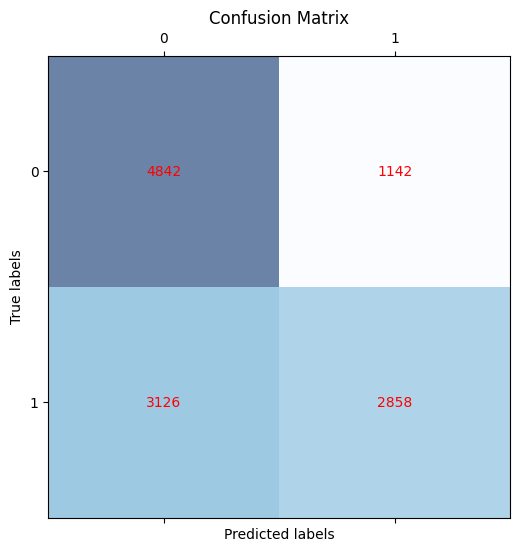

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def cnn_with_smote_sentiment_analysis_balanced(df):
    """Balanced veri seti ile CNN ve SMOTE kullanarak duygu analizi yapar ve sonuçları döner."""
    # Eğitim ve test setine ayırma
    X_train, X_test, y_train, y_test = split_data(df, 'cleaned_review', 'Sentiment')

    # TF-IDF vektörleştirme
    X_train_tfidf, X_test_tfidf, _ = vectorize_text(X_train, X_test)

    # SMOTE ile veri artırımı
    X_train_resampled, y_train_resampled = apply_smote(X_train_tfidf, y_train)

    # CNN Modelini oluştur
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_resampled.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary sınıflandırma için sigmoid
    ])

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Modeli eğit
    model.fit(
        X_train_resampled, y_train_resampled,
        epochs=5,
        batch_size=64,
        validation_data=(X_test_tfidf, y_test)
    )

    # Test seti üzerinde tahmin yap
    y_pred = model.predict(X_test_tfidf)
    y_pred = (y_pred > 0.5).astype(int).flatten()  # Sigmoid çıktıyı 0 veya 1'e dönüştür

    # Sonuçları yazdır
    print("CNN with SMOTE Accuracy (Balanced Data):", accuracy_score(y_test, y_pred))
    print("CNN with SMOTE Classification Report (Balanced Data):\n", classification_report(y_test, y_pred))
    print("CNN with SMOTE Confusion Matrix (Balanced Data):\n", confusion_matrix(y_test, y_pred))

    return accuracy, report, cm

# CNN analizi SMOTE ile balanced_data kullanılarak
accuracy, report, cm = cnn_with_smote_sentiment_analysis_balanced(balanced_data)

# Confusion Matrix'i görselleştir
plot_confusion_matrix(cm)

In [17]:
from gensim.models import Word2Vec
import numpy as np

def train_word2vec(corpus):
    """
    Word2Vec modelini eğitir ve kelimeler için vektörleri döndürür.
    """
    tokenized_corpus = [text.split() for text in corpus]  # Her yorumu tokenize et
    model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)
    return model

def vectorize_text_with_word2vec(texts, model):
    """
    Word2Vec ile metni vektörize eder.
    """
    def average_word_vectors(words, model, vector_size):
        # Her kelimenin vektör ortalamasını al
        feature_vec = np.zeros((vector_size,), dtype='float32')
        n_words = 0
        for word in words:
            if word in model.wv:
                feature_vec = np.add(feature_vec, model.wv[word])
                n_words += 1
        if n_words > 0:
            feature_vec = np.divide(feature_vec, n_words)
        return feature_vec

    vector_size = model.vector_size
    return np.array([average_word_vectors(text.split(), model, vector_size) for text in texts])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Word2Vec Sentiment Analysis Accuracy: 0.7755872483221476
Word2Vec Sentiment Analysis Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.79      0.78      1187
           1       0.78      0.77      0.77      1197

    accuracy                           0.78      2384
   macro avg       0.78      0.78      0.78      2384
weighted avg       0.78      0.78      0.78      2384

Word2Vec Sentiment Analysis Confusion Matrix:
 [[932 255]
 [280 917]]


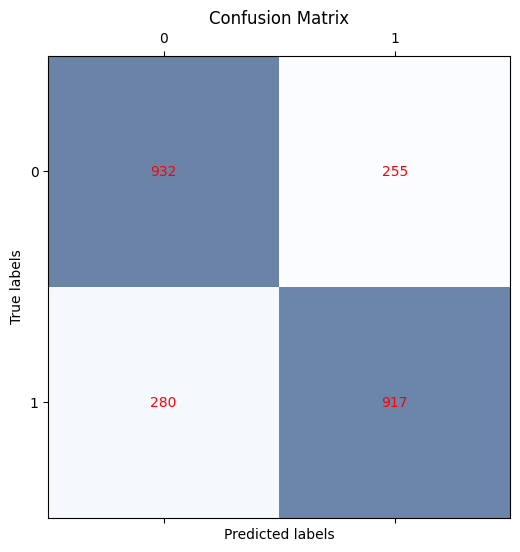

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

def word2vec_sentiment_analysis(df):
    """
    Word2Vec ve bir makine öğrenimi modeli ile duygu analizi yapar.
    """
    # Eğitim ve test setine ayırma
    X_train, X_test, y_train, y_test = split_data(df, 'cleaned_review', 'Sentiment')

    # Word2Vec modelini eğit
    word2vec_model = train_word2vec(X_train)

    # Word2Vec ile veriyi vektörize et
    X_train_vec = vectorize_text_with_word2vec(X_train, word2vec_model)
    X_test_vec = vectorize_text_with_word2vec(X_test, word2vec_model)

    # SMOTE uygula
    X_train_resampled, y_train_resampled = apply_smote(X_train_vec, y_train)

    # Model oluştur ve değerlendir
    model = LogisticRegression(random_state=42)
    accuracy, report, cm = train_and_evaluate_model(model, X_train_resampled, y_train_resampled, X_test_vec, y_test)

    return accuracy, report, cm

# Word2Vec ile duygu analizi fonksiyonunu çalıştır
accuracy_word2vec, report_word2vec, cm_word2vec = word2vec_sentiment_analysis(balanced_data)

# Sonuçları yazdır
print("Word2Vec Sentiment Analysis Accuracy:", accuracy_word2vec)
print("Word2Vec Sentiment Analysis Classification Report:\n", report_word2vec)
print("Word2Vec Sentiment Analysis Confusion Matrix:\n", cm_word2vec)

# Confusion Matrix görselleştirmesi
plot_confusion_matrix(cm_word2vec)

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def prepare_bert_data(texts, labels, tokenizer, max_len=96):
    """BERT için veri hazırlığı: metinleri ve etiketleri tokenlara dönüştürür."""
    input_ids = []
    attention_masks = []

    for text in texts:
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoding['input_ids'])
        attention_masks.append(encoding['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

def bert_sentiment_analysis(df, batch_size=32, max_len=96, epochs=3, gradient_accumulation_steps=4):
    """DistilBERT tabanlı sentiment analizi yapar."""
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')  # Küçük model
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    X = df['cleaned_review'].values
    y = df['Sentiment'].values

    input_ids, attention_masks, labels = prepare_bert_data(X, y, tokenizer, max_len)

    train_size = int(0.8 * len(X))
    train_inputs, test_inputs = input_ids[:train_size], input_ids[train_size:]
    train_masks, test_masks = attention_masks[:train_size], attention_masks[train_size:]
    train_labels, test_labels = labels[:train_size], labels[train_size:]

    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    test_data = TensorDataset(test_inputs, test_masks, test_labels)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size)

    class_weights = torch.tensor([1.0, 5.0]).to(device)  # Pozitif sınıf için ağırlık
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)  # Daha düşük öğrenme oranı

    for epoch in range(epochs):
        total_loss = 0
        for step, batch in enumerate(train_dataloader):
            input_ids, attention_masks, labels = [item.to(device) for item in batch]
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_masks)
            loss = loss_fn(outputs.logits, labels)
            total_loss += loss.item()
            loss.backward()

            if (step + 1) % gradient_accumulation_steps == 0:
                optimizer.step()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_dataloader)}")

    model.eval()
    all_preds = []
    all_labels = []

    for batch in test_dataloader:
        input_ids, attention_masks, labels = [item.to(device) for item in batch]
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print("BERT Sentiment Accuracy:", accuracy)
    print("BERT Sentiment Classification Report:\n", report)
    print("BERT Sentiment Confusion Matrix:\n", cm)

    return accuracy, report, cm

# balanced_data DataFrame'inin önceden tanımlı olduğundan emin olun.
accuracy_bert, report_bert, cm_bert = bert_sentiment_analysis(balanced_data)
plot_confusion_matrix(cm_bert)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances
import numpy as np

def evaluate_recommendations(true_labels, predicted_labels):
    """
    Gerçek etiketler (beğeniler) ve tahmin edilen etiketler (öneriler) arasındaki doğruluğu ölçer.
    """
    relevant_recommendations = [item for item in predicted_labels if item in true_labels]
    num_relevant_recommendations = len(relevant_recommendations)

    precision = num_relevant_recommendations / len(predicted_labels) if len(predicted_labels) > 0 else 0
    recall = num_relevant_recommendations / len(true_labels) if len(true_labels) > 0 else 0
    accuracy = sum(1 for item in true_labels if item in predicted_labels) / len(true_labels) if len(true_labels) > 0 else 0

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")

def content_based_recommendation(df, user_id, top_n=5):
    # Kullanıcıya ait yorumları al
    user_reviews = df[df['UserId'] == user_id]

    # Temizlenmiş yorumları ve ürün ID'lerini al
    user_reviews = user_reviews[['cleaned_review', 'ProductId', 'Sentiment']]

    # Boş yorumları kontrol et ve kaldır
    user_reviews = user_reviews[user_reviews['cleaned_review'] != '']

    # Yeterli yorum yoksa, öneri yapılamaz
    if len(user_reviews) == 0:
        print(f"User {user_id} için yeterli yorum bulunamadı. Öneri yapılamıyor.")
        return []

    # TF-IDF modelini fit et (hem kullanıcı yorumları hem de tüm ürün yorumları için aynı model)
    tfidf_model = TfidfVectorizer(stop_words='english')
    all_reviews = df['cleaned_review'].tolist() + user_reviews['cleaned_review'].tolist()
    tfidf_matrix_all = tfidf_model.fit_transform(all_reviews)

    # Kullanıcı yorumları için vektörleştirme
    X_user = tfidf_matrix_all[-len(user_reviews):]

    # Tüm ürünlerin yorumları için vektörleştirme
    X_all_products = tfidf_matrix_all[:len(df)]

    # Kullanıcı yorumları ile tüm ürünler arasındaki benzerlik hesapla
    similarities = cosine_similarity(X_user, X_all_products)

    # Benzerlikleri yüksekten düşüğe sıralama
    top_n_indices = similarities.argsort()[:, -top_n:]

    # En benzer ürünlerin ID'lerini al
    recommended_product_ids = df['ProductId'].iloc[top_n_indices.flatten()].unique()

    # Gerçek beğenileri (yani kullanıcı tarafından beğenilen ürünler) al
    true_labels = df[(df['UserId'] == user_id) & (df['Sentiment'] == 1)]['ProductId'].values

    # Gerçek ve tahmin edilen etiketler
    predicted_labels = recommended_product_ids

    # Performansı ölç
    evaluate_recommendations(true_labels, predicted_labels)

    return recommended_product_ids

def collaborative_filtering(df, user_id, top_n=5):
    """
    Kullanıcılar arasındaki benzerliklere dayalı işbirlikçi filtreleme öneri sistemi.
    """
    user_reviews = df[df['UserId'] == user_id]
    user_reviews = user_reviews[['ProductId', 'Sentiment']]

    # Kullanıcılar arası benzerlik hesaplamak için pivot tablosu oluştur
    user_product_matrix = df.pivot_table(index='UserId', columns='ProductId', values='Sentiment', aggfunc='mean').fillna(0)

    # Kullanıcılar arasındaki benzerlik matrisi (pearson correlation)
    user_similarity = 1 - pairwise_distances(user_product_matrix, metric='cosine')

    # Bu kullanıcıya benzer kullanıcıların ID'lerini bul
    user_idx = user_product_matrix.index.get_loc(user_id)
    similar_users = user_similarity[user_idx].argsort()[-top_n-1:-1][::-1]

    # Benzer kullanıcılardan gelen ürünleri öner
    similar_user_ids = user_product_matrix.index[similar_users]
    recommended_products = []

    for similar_user_id in similar_user_ids:
        similar_user_reviews = df[df['UserId'] == similar_user_id]
        recommended_products.extend(similar_user_reviews['ProductId'].tolist())

    recommended_product_ids = list(set(recommended_products))[:top_n]
    true_labels = user_reviews[user_reviews['Sentiment'] == 1]['ProductId'].values
    predicted_labels = recommended_product_ids

    evaluate_recommendations(true_labels, predicted_labels)

    return recommended_product_ids

# İlk 'UserId' değerini almak
user_id = balanced_data['UserId'].iloc[0]
print("İlk UserId:", user_id)

# Kullanıcı için içerik tabanlı öneriler
recommended_product_ids_content = content_based_recommendation(balanced_data, user_id, top_n=5)
print("İçerik Tabanlı Önerilen Ürünler:", recommended_product_ids_content)

# Kullanıcı için işbirlikçi filtreleme önerileri
recommended_product_ids_collaborative = collaborative_filtering(balanced_data, user_id, top_n=5)
print("İşbirlikçi Filtreleme Önerilen Ürünler:", recommended_product_ids_collaborative)

İlk UserId: A23FXN3MH1F00D
Precision: 0.2
Recall: 1.0
Accuracy: 1.0
İçerik Tabanlı Önerilen Ürünler: ['B001EO5Y8Y' 'B00474CSVE' 'B0001ES9FI' 'B005ZBZLT4' 'B007Y59HVM']
Precision: 1.0
Recall: 1.0
Accuracy: 1.0
İşbirlikçi Filtreleme Önerilen Ürünler: ['B007Y59HVM']


In [20]:
def hybrid_recommendation(df, user_id, top_n=5, alpha=0.5):
    """
    Hibrit öneri sistemi: İçerik tabanlı ve işbirlikçi filtreleme sonuçlarını birleştirir.
    """
    # İçerik tabanlı öneri sisteminden ürünleri al
    content_recommended = content_based_recommendation(df, user_id, top_n=top_n)

    # İşbirlikçi filtreleme öneri sisteminden ürünleri al
    collaborative_recommended = collaborative_filtering(df, user_id, top_n=top_n)

    # İçerik tabanlı ve işbirlikçi filtreleme sonuçlarının kesişimi
    hybrid_recommended = list(set(content_recommended).intersection(set(collaborative_recommended)))

    # Eğer kesişim yoksa, içerik ve işbirlikçi öneri sonuçlarını ağırlıklı bir şekilde birleştir
    if len(hybrid_recommended) == 0:
        hybrid_recommended = content_recommended[:int(top_n * alpha)] + collaborative_recommended[:int(top_n * (1 - alpha))]

    # Ağırlıklı birleştirilmiş sonuçları döndür
    return hybrid_recommended

# İlk 'UserId' değerini almak
user_id = balanced_data['UserId'].iloc[0]
print("İlk UserId:", user_id)

# Hibrit öneri sistemi ile ürünleri almak
recommended_product_ids_hybrid = hybrid_recommendation(balanced_data, user_id, top_n=5, alpha=0.5)
print("Hibrit Önerilen Ürünler:", recommended_product_ids_hybrid)

# Hibrit önerilerin performansını ölçmek
true_labels = balanced_data[balanced_data['UserId'] == user_id][balanced_data['Sentiment'] == 1]['ProductId'].values
predicted_labels = recommended_product_ids_hybrid
evaluate_recommendations(true_labels, predicted_labels)

İlk UserId: A23FXN3MH1F00D
Precision: 0.2
Recall: 1.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Accuracy: 1.0
Hibrit Önerilen Ürünler: ['B007Y59HVM']
Precision: 1.0
Recall: 1.0
Accuracy: 1.0


<ipython-input-20-69d5f22a6a1f>:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  true_labels = balanced_data[balanced_data['UserId'] == user_id][balanced_data['Sentiment'] == 1]['ProductId'].values


Precision: 0.2
Recall: 1.0
Accuracy: 1.0


<ipython-input-21-4be2eeac0a88>:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  true_labels = df[df['UserId'] == user_id][df['Sentiment'] == 1]['ProductId'].values


Precision: 1.0
Recall: 1.0
Accuracy: 1.0


<ipython-input-21-4be2eeac0a88>:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  true_labels = df[df['UserId'] == user_id][df['Sentiment'] == 1]['ProductId'].values


Precision: 0.2
Recall: 1.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Accuracy: 1.0


<ipython-input-21-4be2eeac0a88>:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  true_labels = df[df['UserId'] == user_id][df['Sentiment'] == 1]['ProductId'].values


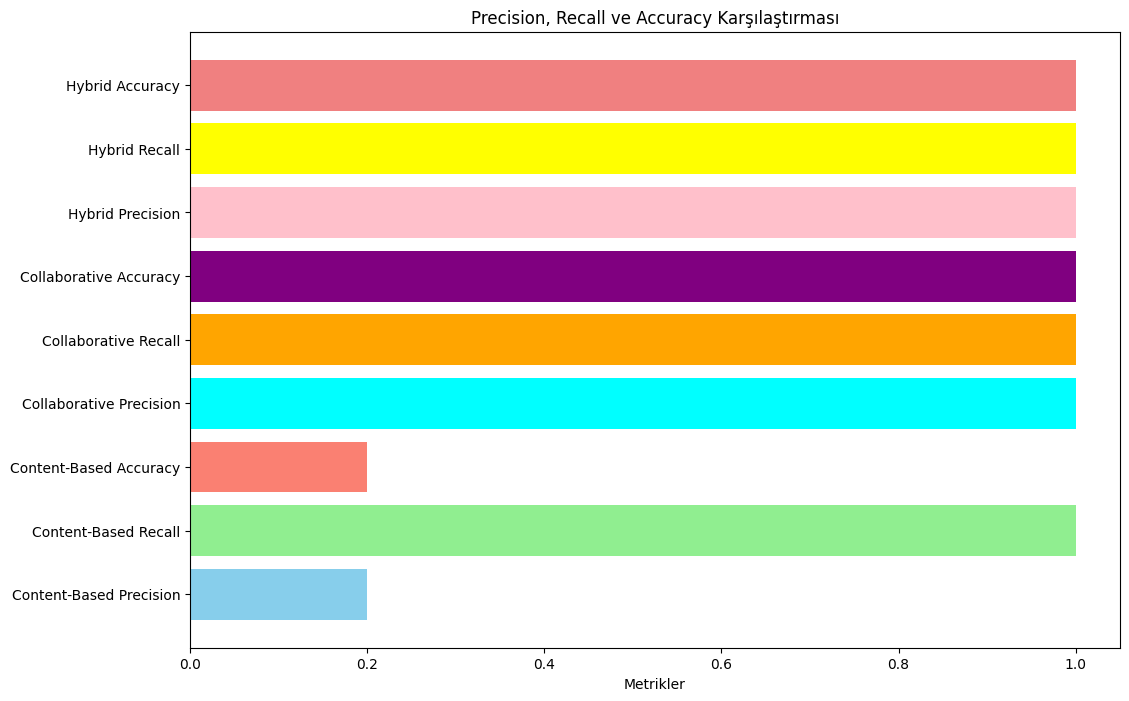

In [21]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

def plot_metrics_comparison(precision_content, recall_content, accuracy_content,
                            precision_collab, recall_collab, accuracy_collab,
                            precision_hybrid, recall_hybrid, accuracy_hybrid):
    """
    Precision, recall ve accuracy metriklerini karşılaştıran bir bar grafiği oluşturur.
    """
    metrics = [precision_content, recall_content, accuracy_content,
               precision_collab, recall_collab, accuracy_collab,
               precision_hybrid, recall_hybrid, accuracy_hybrid]

    method_names = ['Content-Based Precision', 'Content-Based Recall', 'Content-Based Accuracy',
                    'Collaborative Precision', 'Collaborative Recall', 'Collaborative Accuracy',
                    'Hybrid Precision', 'Hybrid Recall', 'Hybrid Accuracy']

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.barh(method_names, metrics, color=['skyblue', 'lightgreen', 'salmon', 'cyan', 'orange', 'purple', 'pink', 'yellow', 'lightcoral'])
    ax.set_xlabel('Metrikler')
    ax.set_title('Precision, Recall ve Accuracy Karşılaştırması')

    plt.show()

# Öneri metriklerinin hesaplanması için
def get_recommended_products_for_evaluation(df, user_id, method="content", top_n=5):
    """
    İçerik tabanlı, işbirlikçi veya hibrit öneriler için öneri ürünlerini döndüren fonksiyon.
    """
    if method == "content":
        predicted_labels = content_based_recommendation(df, user_id, top_n)
    elif method == "collaborative":
        predicted_labels = collaborative_filtering(df, user_id, top_n)
    elif method == "hybrid":
        predicted_labels = hybrid_recommendation(df, user_id, top_n)
    else:
        raise ValueError("Geçersiz yöntem seçimi.")

    # Gerçek etiketler (beğenilen ürünler) almak
    true_labels = df[df['UserId'] == user_id][df['Sentiment'] == 1]['ProductId'].values

    # Performansı ölçmek için değerlendirme fonksiyonu çağır
    return true_labels, predicted_labels

# Örnek kullanıcı ID'si
user_id = balanced_data['UserId'].iloc[0]

# İçerik tabanlı öneri
true_labels, content_predicted = get_recommended_products_for_evaluation(balanced_data, user_id, method="content", top_n=5)

# İşbirlikçi öneri
_, collaborative_predicted = get_recommended_products_for_evaluation(balanced_data, user_id, method="collaborative", top_n=5)

# Hibrit öneri
_, hybrid_predicted = get_recommended_products_for_evaluation(balanced_data, user_id, method="hybrid", top_n=5)

# Binary encoding for Precision, Recall, Accuracy calculation
def get_binary_encoding(true_labels, predicted_labels):
    binary_true = [1 if item in true_labels else 0 for item in predicted_labels]
    return binary_true

# Metrik hesaplamaları
precision_content = precision_score(get_binary_encoding(true_labels, content_predicted), [1]*len(content_predicted), zero_division=1)
recall_content = recall_score(get_binary_encoding(true_labels, content_predicted), [1]*len(content_predicted), zero_division=1)
accuracy_content = accuracy_score(get_binary_encoding(true_labels, content_predicted), [1]*len(content_predicted))

precision_collab = precision_score(get_binary_encoding(true_labels, collaborative_predicted), [1]*len(collaborative_predicted), zero_division=1)
recall_collab = recall_score(get_binary_encoding(true_labels, collaborative_predicted), [1]*len(collaborative_predicted), zero_division=1)
accuracy_collab = accuracy_score(get_binary_encoding(true_labels, collaborative_predicted), [1]*len(collaborative_predicted))

precision_hybrid = precision_score(get_binary_encoding(true_labels, hybrid_predicted), [1]*len(hybrid_predicted), zero_division=1)
recall_hybrid = recall_score(get_binary_encoding(true_labels, hybrid_predicted), [1]*len(hybrid_predicted), zero_division=1)
accuracy_hybrid = accuracy_score(get_binary_encoding(true_labels, hybrid_predicted), [1]*len(hybrid_predicted))

# Görselleştirme
plot_metrics_comparison(precision_content, recall_content, accuracy_content,
                        precision_collab, recall_collab, accuracy_collab,
                        precision_hybrid, recall_hybrid, accuracy_hybrid)

Precision: 0.2
Recall: 1.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Accuracy: 1.0
Precision: 0.2
Recall: 1.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Accuracy: 1.0


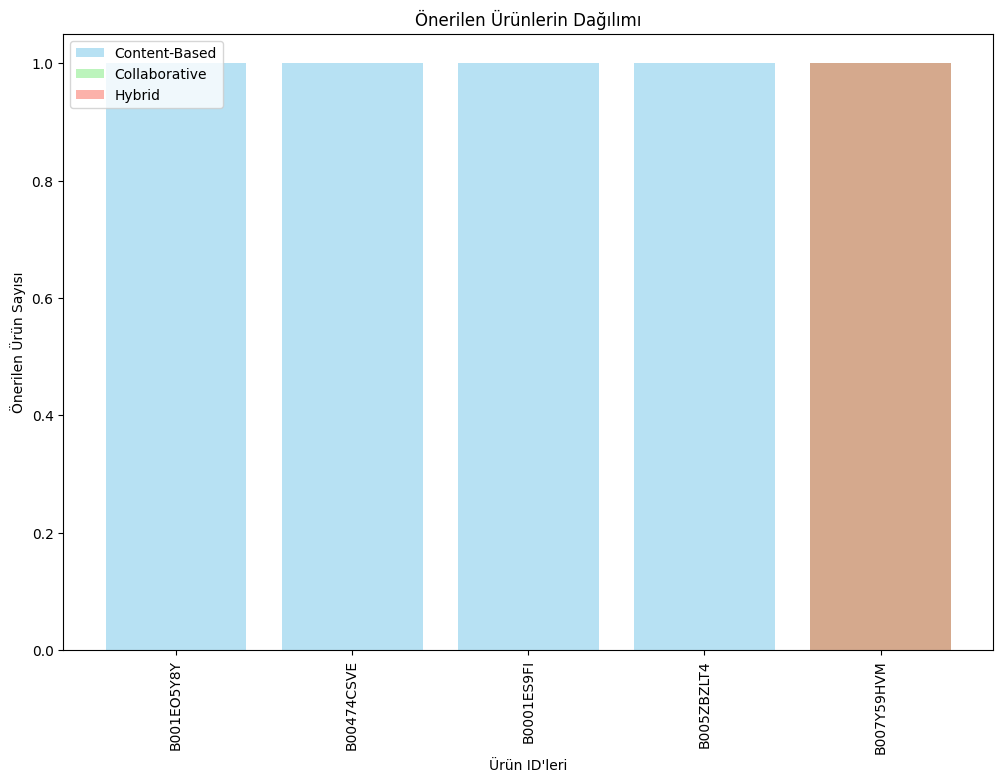

In [22]:
from collections import Counter

def plot_recommended_products_distribution(content_predicted, collaborative_predicted, hybrid_predicted):
    """
    Üç farklı öneri yöntemine göre önerilen ürünlerin dağılımını gösterir.
    """
    # Ürünlerin sayısını say
    content_product_counts = Counter(content_predicted)
    collaborative_product_counts = Counter(collaborative_predicted)
    hybrid_product_counts = Counter(hybrid_predicted)

    # Ürünleri ve sayıları al
    content_products, content_counts = zip(*content_product_counts.items())
    collaborative_products, collaborative_counts = zip(*collaborative_product_counts.items())
    hybrid_products, hybrid_counts = zip(*hybrid_product_counts.items())

    # Grafiği oluştur
    fig, ax = plt.subplots(figsize=(12, 8))

    ax.bar(content_products, content_counts, label="Content-Based", color='skyblue', alpha=0.6)
    ax.bar(collaborative_products, collaborative_counts, label="Collaborative", color='lightgreen', alpha=0.6)
    ax.bar(hybrid_products, hybrid_counts, label="Hybrid", color='salmon', alpha=0.6)

    ax.set_xlabel('Ürün ID\'leri')
    ax.set_ylabel('Önerilen Ürün Sayısı')
    ax.set_title('Önerilen Ürünlerin Dağılımı')
    ax.legend()

    plt.xticks(rotation=90)
    plt.show()

# Dinamik olarak öneri sistemlerinin çıktısını almak
content_predicted = content_based_recommendation(balanced_data, user_id, top_n=5)
collaborative_predicted = collaborative_filtering(balanced_data, user_id, top_n=5)
hybrid_predicted = hybrid_recommendation(balanced_data, user_id, top_n=5)

# Görselleştirme
plot_recommended_products_distribution(content_predicted, collaborative_predicted, hybrid_predicted)